# Forcasting_CNN Best our best result
Comparing this CNN with the other 2 approches we tried, this CNN approch gave us the best result.

[I am following this notebook](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb#scrollTo=vidayERjaO5q)

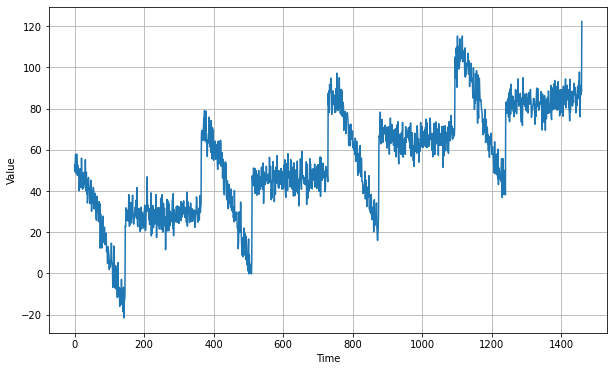

In [1]:
# setup

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

slope = 0.05
baseline = 10
amplitude = 40
time = np.arange(4 * 365 + 1)

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in [1,2,4,8,16, 32]:
  model.add(
      keras.layers.Conv1D(
          filters=32,
          kernel_size=2,
          strides=1,
          dilation_rate=dilation_rate,
          padding="causal",
          activation='relu',
      )      
  )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 30)
    )

optimizer = keras.optimizers.Adam(lr = 1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])



Epoch 1/100
8/8 [==============================] - 0s 47ms/step - loss: 42.2341 - mae: 42.7330 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 49ms/step - loss: 41.8293 - mae: 42.3284 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 50ms/step - loss: 41.4367 - mae: 41.9357 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 50ms/step - loss: 41.0108 - mae: 41.5098 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 52ms/step - loss: 40.4787 - mae: 40.9776 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 50ms/step - loss: 39.7341 - mae: 40.2328 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 50ms/step - loss: 38.5884 - mae: 39.0871 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 55ms/step - loss: 36.6836 - mae: 37.1823 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 51ms/step - loss: 33.3644 - mae: 33.8629 - lr: 1.8

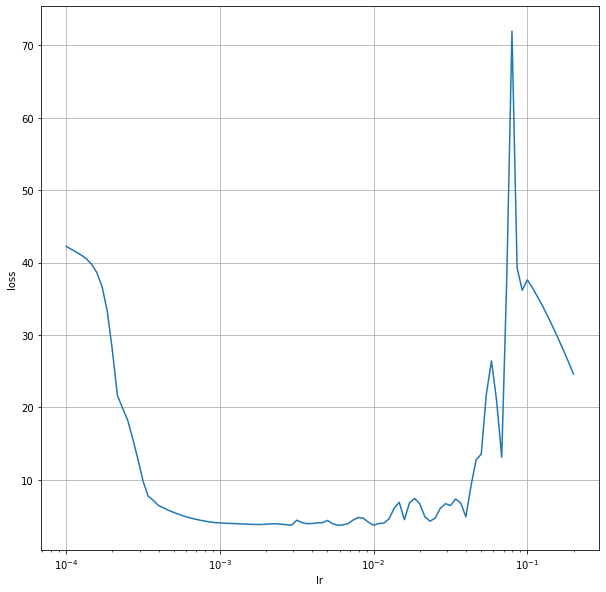

In [10]:
plt.figure(figsize=(10,10), facecolor='w')
plt.xlabel('lr')
plt.ylabel('loss')
plt.grid()
plt.semilogx(history.history["lr"], history.history["loss"])


In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=2e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 132ms/step - loss: 33.7582 - mae: 34.2566 - val_loss: 32.9981 - val_mae: 33.4956
Epoch 2/500
8/8 [==============================] - 1s 70ms/step - loss: 19.9238 - mae: 20.4185 - val_loss: 24.5248 - val_mae: 25.0207
Epoch 3/500
8/8 [==============================] - 1s 71ms/step - loss: 13.4440 - mae: 13.9349 - val_loss: 15.1831 - val_mae: 15.6777
Epoch 4/500
8/8 [==============================] - 1s 74ms/step - loss: 8.4415 - mae: 8.9273 - val_loss: 10.0856 - val_mae: 10.5748
Epoch 5/500
8/8 [==============================] - 1s 73ms/step - loss: 6.7970 - mae: 7.2814 - val_loss: 6.5823 - val_mae: 7.0639
Epoch 6/500
8/8 [==============================] - 1s 68ms/step - loss: 5.3026 - mae: 5.7831 - val_loss: 6.0055 - val_mae: 6.4885
Epoch 7/500
8/8 [==============================] - 1s 74ms/step - loss: 4.8543 - mae: 5.3341 - val_loss: 4.7977 - val_mae: 5.2765
Epoch 8/500
8/8 [==============================] - 1s 71ms/step - loss: 4.5

4.626052

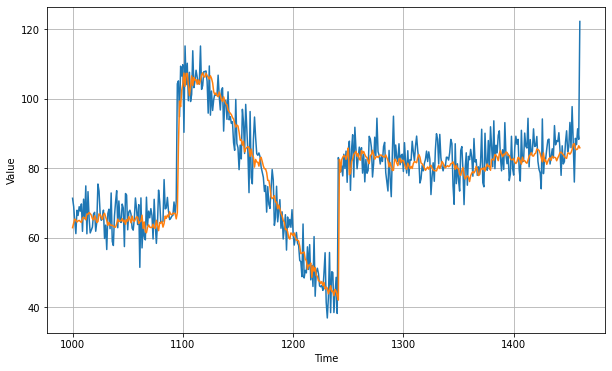

In [13]:
model = keras.models.load_model('my_checkpoint.h5')
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6), facecolor='w')
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

## WOHOW the best forcast we have so far